In [1]:
from zipfile import ZipFile
import pathlib
from datetime import datetime
from dateutil import parser

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The `sentiment140` dataset contains 1,600,000 tweets extracted using the twitter api.

The tweets have been annotated *(0 = negative, 4 = positive)* and they can be used to detect sentiment.

It contains the following 6 fields:
- `target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- `ids`: The id of the tweet ( 2087)
- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.
- `user`: the user that tweeted (robotickilldozr)
- `text`: the text of the tweet (Lyx is cool)

In [2]:
source = pathlib.Path(pathlib.Path().absolute(), 'data', 'sentiment140.zip')

In [3]:
# Method 2
df = pd.read_csv(
    source, 
    compression='zip', 
    encoding='cp1252', 
    header=None, 
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    #parse_dates=['date'],
    #infer_datetime_format=True,
    #date_parser=parse_tweet_dates,
)

In [4]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1600000, 6)

#### Regardons les types des colonnes et ajustons si nécessaire

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df = df.astype({
    "target": 'category', 
    "ids": 'category',
    #"date": 'datetime64',
    "flag": 'category',
    "user": 'category',
    #"text": 'object',
})

In [7]:
df.dtypes

target    category
ids       category
date        object
flag      category
user      category
text        object
dtype: object

In [8]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


### Analysons la colonne `target`
#### Regardons sa distribution

In [9]:
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

>#### On constate donc que les targets sont équitablement distribuées entre 0 *(negative)* et 4 *(positive)*, mais qu'il n'y a pas de 2 *(neutral)*
> il n'est donc pas nécessaire d'effectuer un ré-équilibrage, mais nous pourrions changer la colonne en bool ou rendre les labels plus clairs.

In [10]:
remap = {0: "negative", 4: "positive"}
df.replace({"target": remap}, inplace=True)

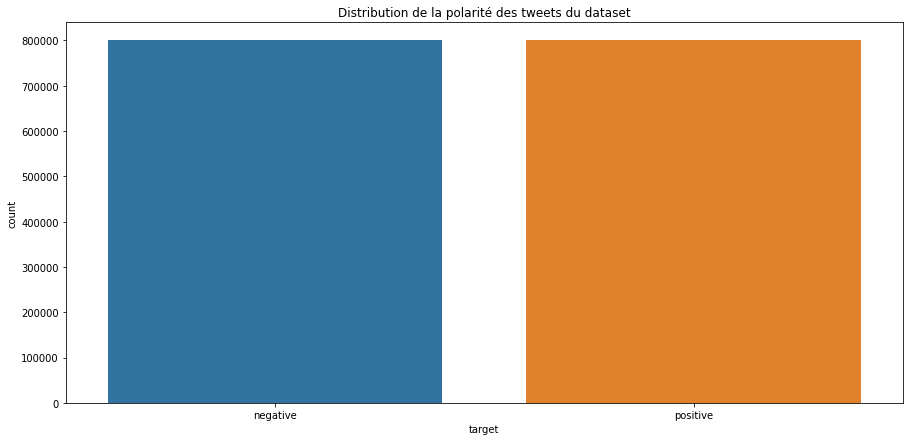

In [11]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(data=df.target.value_counts().reset_index().rename(columns={'target':'count', 'index':'target'}), x='target', y='count')
plt.title("Distribution de la polarité des tweets du dataset")
plt.show()

### Analysons la colonne `ids`

In [12]:
df.ids.duplicated().sum()

1685

In [13]:
subset = ['ids']
df[df.duplicated(keep='first', subset=subset)]

,target,ids,date,flag,user,text
800261,positive,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...
800300,positive,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...
801280,positive,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...
801573,positive,1468100580,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,cristygarza,good night swetdreamss to everyonee and jare...
801650,positive,1468115720,Mon Apr 06 23:48:00 PDT 2009,NO_QUERY,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...
...,...,...,...,...,...,...
1598780,positive,2193278017,Tue Jun 16 08:14:22 PDT 2009,NO_QUERY,janiecwales,oh dear HH is back please twitter do somethi...
1599298,positive,2193403830,Tue Jun 16 08:24:44 PDT 2009,NO_QUERY,lauren__x33,english exam went okay revising for fre...
1599385,positive,2193428118,Tue Jun 16 08:26:44 PDT 2009,NO_QUERY,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
1599440,positive,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."


In [14]:
df[df.duplicated(keep='last', subset=subset)]

,target,ids,date,flag,user,text
213,negative,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...
275,negative,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...
989,negative,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...
1177,negative,1468100580,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,cristygarza,good night swetdreamss to everyonee and jare...
1254,negative,1468115720,Mon Apr 06 23:48:00 PDT 2009,NO_QUERY,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...
...,...,...,...,...,...,...
523869,negative,2193278017,Tue Jun 16 08:14:22 PDT 2009,NO_QUERY,janiecwales,oh dear HH is back please twitter do somethi...
524213,negative,2193403830,Tue Jun 16 08:24:44 PDT 2009,NO_QUERY,lauren__x33,english exam went okay revising for fre...
524290,negative,2193428118,Tue Jun 16 08:26:44 PDT 2009,NO_QUERY,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
524345,negative,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."


>#### On constate que l'on a 1685 échantillons pour lesquels on a à la fois une target *positive* et une target *negative*...
> comme on ne connait pas la véritable target des ces échantillons en double, il nous faut supprimer les 3370 *(2 x 1685)*

In [15]:
df.drop_duplicates(keep=False, subset=subset, inplace=True)

In [16]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1596630, 6)

In [17]:
df.ids.duplicated().sum()

0

In [18]:
df.ids.describe()

count        1596630
unique       1596630
top       1467810369
freq               1
Name: ids, dtype: int64

### Analysons la colonne `date`

In [23]:
def parse_tweet_dates(date_time_str):
    return parser.parse(date_time_str,  tzinfos={"PDT": -7*3600})

In [ ]:
df['date'] = df.date.apply(parse_tweet_dates)

In [ ]:
display(df.head(2), df.shape)

#### Regardons les limites de la periode de publication des tweets de notre dataset

In [ ]:
df.date.describe(datetime_is_numeric=True)

>#### On a donc des tweets dont les dates s'étalent du 06/04/2009 au 25/06/2009
> Il n'y a pas de raison que le lexique utilisé pour qualifier ce qui est *positif* ou *négatif* change en si peu de temps, donc on peut conserver l'ensemble de l'intervalle

#### Regardons à présent la distribution des tweet dans le temps

In [8]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, x_label=None, y_label="Nombre de commandes"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [ ]:
selection = data_orders[['order_id', 'order_purchase_timestamp']].copy()
selection['short_date'] = selection.order_purchase_timestamp.apply(lambda x: x[:10])
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T
    
plot_bars(selection, "Répartition des commandes dans le temps (par jours)", labels_modulo=30, show_values=False)

### Analysons la colonne `flag`

In [19]:
df.flag.value_counts(dropna=False)

NO_QUERY    1596630
Name: flag, dtype: int64

>#### Il n'y a qu'une seule valeur dans cette colonne
> elle ne présente donc aucun intérêt et peut être retirée.

In [21]:
df.drop(columns=['flag'], inplace=True)

In [22]:
display(df.head(2), df.shape)

,target,ids,date,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


(1596630, 5)

### Analysons la colonne `user`

### Analysons la colonne `text`

In [ ]:
data_df[data_df.duplicated(keep=False, subset=['text'])].sort_values('text')